In [ ]:
!pip install auto-sklearn &> /dev/null
!pip uninstall -y scipy &> /dev/null
!pip install scipy==1.7.3 &> /dev/null
!pip install xlrd==2.0.0 &> /dev/null
!pip install scikit-multiflow &> /dev/null
print('Installs finished')

Installs finished


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime,date
from itertools import compress
import matplotlib.pyplot as plt
import random
from random import sample
from sklearn.base import TransformerMixin
import pickle
import autosklearn.classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import glob
from time import time
from sklearn.model_selection import train_test_split
from skmultiflow.drift_detection import DDM, ADWIN, EDDM, HDDM_A, PageHinkley
import math

rng = np.random.default_rng(4711)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
commentsDF = pd.DataFrame(columns={'ID'})
for file in glob.glob("/content/drive/MyDrive/MA/Daten/*"):
     tempDF = pd.read_excel(file)
     commentsDF = pd.concat([commentsDF, tempDF], join='outer')

commentsDF = commentsDF.drop(columns=['ID', 'Active', 'CID', 'Sperrhinweis', 'Loginname'],axis=1)

commentsDF['Date'] =  pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d %H:%M:%S')
commentsDF['Time'] = pd.to_datetime(commentsDF['Date']).dt.time
commentsDF['Date'] = pd.to_datetime(commentsDF['Date']).dt.date
commentsDF['Date'] = pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d')

commentsDF['Text'] = commentsDF['Text'].astype(str)
commentsDF['Title'] = commentsDF['Title'].astype(str)

commentsDF = commentsDF.drop_duplicates(subset=['Text']) 
commentsDF = commentsDF.sort_values(by=['Date']).reset_index(drop=True)

In [ ]:
# creates Sampled down version of dataset

dateRange = pd.period_range(start='2018-11-01', end='2020-06-01', freq='M')
timeSampledDF = pd.DataFrame(columns={'ID'})


for i in range(len(dateRange)):
  month = dateRange[i].month
  year = dateRange[i].year
  monthData = commentsDF[(commentsDF.Date.dt.month == dateRange[i].month) & (commentsDF.Date.dt.year == dateRange[i].year)]
  countMinor = len(monthData[monthData.Abgelehnt == 1])
  if countMinor < 600:
    countMinor = 600
  minorityDF = monthData[monthData.Abgelehnt == 1]
  majorityDF = monthData[monthData.Abgelehnt == 0].sample(axis='index', 
                                                          n=countMinor, 
                                                          random_state=4711,)
  timeSampledDF = pd.concat([timeSampledDF, majorityDF], join='outer')
  timeSampledDF = pd.concat([timeSampledDF, minorityDF], join='outer')

y_vals = commentsDF['Abgelehnt'].values
y_vals = y_vals.astype(int)


commentsDF['index1'] = commentsDF.index
timeSampledDF['index1'] = timeSampledDF.index
timeSampledDF.sort_values(by='Date',inplace=True)

commentsDF['Mask'] = commentsDF.index1.apply(lambda x: 1 if x in timeSampledDF.index1 else 0)
mask = np.array(commentsDF['Mask']).astype('bool')
y_vals_sample = timeSampledDF['Abgelehnt'].values
y_vals_sample = y_vals_sample.astype(int)

In [ ]:
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", 
                                 "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, 
                                names=['stopwords'])['stopwords'].to_list()

vectorizer = TfidfVectorizer(stop_words=german_stop_words, 
                             ngram_range=(1,2),max_features=3000)

# preprocessor = TextPreprocessingTransformer()
# preprocessed = preprocessor.transform(np.array(timeSampledDF["Text"]))

# with open('sample_preprocessed.pk', 'wb') as fin:
#     pickle.dump(preprocessed, fin)

tfidf_pickle = open ("/content/drive/MyDrive/MA/preprocessed_balanced.pk", "rb")
preprocessed = pickle.load(tfidf_pickle)

# tfidf = vectorizer.fit_transform(preprocessed)

### AutoML Model trained on time-framed data


In [ ]:
train_batch = np.array((timeSampledDF.Date < "2019-11-01") & (timeSampledDF.Date >= "2019-08-01"))
test = timeSampledDF['Date'] >= "2019-11-01"

x_timed = list(compress(preprocessed, train_batch))

y_train_timed = y_vals_sample[train_batch]
x_train_timed = vectorizer.fit_transform(x_timed).toarray()

# automl_timed_3m = autosklearn.classification.AutoSklearnClassifier(
#     time_left_for_this_task=360,
#     n_jobs=-1,
#     metric = autosklearn.metrics.f1
# )

# automl_timed_3m.fit(x_train_timed, y_train_timed)

In [ ]:
automl_timed_load = open ("/content/drive/MyDrive/MA/autoML_timed_balanced.pk", "rb")
automl_timed = pickle.load(automl_timed_load)

In [ ]:
train_batch = np.array(timeSampledDF.Date < "2019-11-01")
test = timeSampledDF['Date'] >= "2019-11-01"

In [ ]:
x_timed = list(compress(preprocessed, train_batch))
vectorizer = vectorizer.fit(x_timed)

In [ ]:
x_test = list(compress(preprocessed, np.array(test)))

x_test_timed = vectorizer.transform(x_test).toarray()
y_test_timed = y_vals_sample[test]

y_pred_timed = automl_timed.predict(x_test_timed)

In [ ]:
def createDriftDF(detector, model, vectorizer, method, datastream):
  refitModel = model
  buffer = 0
  testRange = []
  driftDF = pd.DataFrame(columns=['Date', 'Drift'])
  driftDF['Date'] = timeSampledDF[test]['Date'] 
  batch = []
  batch = pd.DataFrame()
  # batching
  for i in range(len(datastream)):
 
    batch = batch.append(datastream.iloc[i])
    if(len(batch) >= 500):
      if(0<buffer<500):
        buffer += 1
      else:
        x_transform = vectorizer.transform(batch.x).toarray()
        y_pred = refitModel.predict(x_transform)
        if (method == 4): 
          errors = [1 if i == j else 0 for i, j in zip(batch.y, y_pred)]
        else:
          errors =  abs(batch.y - y_pred)

        for error in errors:
          detector.add_element(error)

          if(detector.detected_change()):
            driftDF['Drift'].iloc[i] = 1
            print("Drift detected at", datastream.Date.iloc[i])
            buffer = 0
            batch = pd.DataFrame()
            break

          else:
            buffer = 1
  # driftDF['Mis Prob'] = misclassificationProb
  # driftDF['Mis Dev'] = misclassificationDev
  driftDF.dropna(inplace=True)
  driftDF['Method'] = method
  return driftDF

In [ ]:
def getDriftPoints(detector, datastream, method):
  testRange = []
  driftDF = pd.DataFrame(columns=['Date', 'Drift'])
  driftDF['Date'] =  timeSampledDF[test]['Date']
  batch = []

  for i in range(len(datastream)):
    testRange.append(x_test_timed[i])
    batch.append(datastream[i])
    if(len(batch)>500):
      for value in batch:
        detector.add_element(value)
        # if ddm.detected_warning_zone():
        #   print("Warning zone has been detected in data: {} "
        #   "- of index: {}".format(datastream[i],i))
        if (detector.detected_change()):
          # print("Change has been detected at {} ".format(timeSampledDF[test].iloc[i].Date))
          driftDF.Drift.iloc[i] = 1
          testRange = []
        batch = []

  driftDF.dropna(inplace=True)
  driftDF['Method'] = method
  return driftDF

In [ ]:
preprocessFrame = timeSampledDF
preprocessFrame.Text = preprocessed
testMask = timeSampledDF.Date >= "2019-11-01"

datastream = preprocessFrame[testMask][['Text', 'Abgelehnt', 'Date']].copy().sort_values(by='Date')
datastream.rename(columns={'Text':'x', 'Abgelehnt':'y'}, inplace=True)

# Drift with regular Model

In [ ]:
ddm = DDM()
ddmDrift = createDriftDF(ddm, automl_timed, vectorizer, 1, datastream)

In [ ]:
ddm = DDM()
ddmDrift = createDriftDF(ddm, automl_timed, vectorizer, 1, datastream)

eddm = EDDM()
eddmDrift = createDriftDF(eddm, automl_timed, vectorizer, 2, datastream)

hddm = HDDM_A()
hddmDrift = createDriftDF(hddm, automl_timed, vectorizer, 3, datastream)

adwin = ADWIN(delta=0.0002)
adwinDrift = createDriftDF(adwin, automl_timed, vectorizer, 4, datastream)

ph = PageHinkley()
phDrift = createDriftDF(ph, automl_timed, vectorizer, 5, datastream)

In [ ]:
# ddmDrift.dropna(inplace=True)
# eddmDrift.dropna(inplace=True)
# hddmDrift.dropna(inplace=True)
# adwinDrift.dropna(inplace=True)
# phDrift.dropna(inplace=True)

In [ ]:
plotDF = pd.concat([ddmDrift, eddmDrift, hddmDrift, adwinDrift, phDrift]).sort_values(by='Method')


In [ ]:
plotDF.Drift = plotDF.Drift.astype(int)
voteDF = plotDF.groupby('Date').sum()

In [ ]:
voteDF['Drift'] = np.where(voteDF.Drift >= 3, 1, np.nan)
voteDF.dropna(inplace=True)


In [ ]:
voteDF

,Drift,Method
Date,,
2019-11-08,1.0,6
2019-11-18,1.0,14
2020-04-01,1.0,10
2020-05-17,1.0,6
2020-06-20,1.0,14


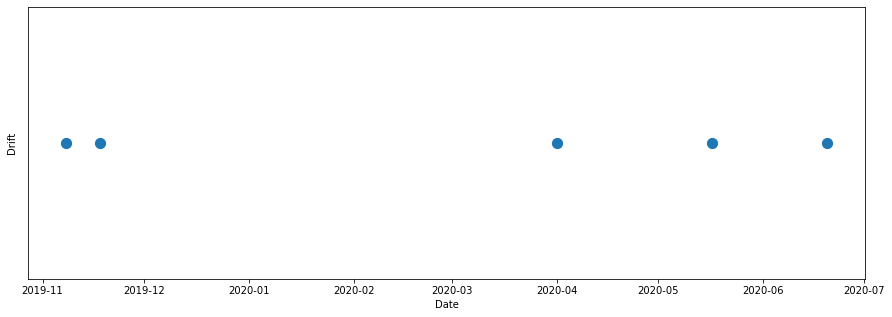

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))

scat = sns.scatterplot(data=voteDF, x="Date", y="Drift",
                                palette='deep', s=150, legend=False)

scat.set_yticklabels([])
scat.tick_params(left=False)

[Text(0, 0, 'DDM'),
 Text(0, 0, 'EDDM'),
 Text(0, 0, 'HDDM_A'),
 Text(0, 0, 'ADWIN'),
 Text(0, 0, 'Page Hinkley')]

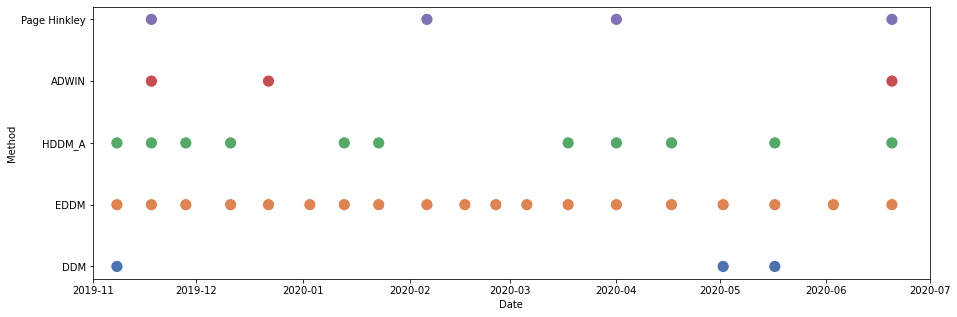

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))

fig.add_subplot(sns.scatterplot(data=plotDF, x="Date", y="Method", hue="Method",
                                palette='deep', s=150, legend=False))
ax.set_yticks(np.arange(1,6))
ax.set_xlim([date(2019,11,1), date(2020,7,1)])
ax.set_yticklabels(['DDM', 'EDDM', 'HDDM_A', 'ADWIN', 'Page Hinkley'])

# Drift with 3 month Model

In [ ]:
ddm = DDM(out_control_level=2.0)
ddmDrift = createDriftDF(ddm, automl_timed_3m, vectorizer, 1, datastream)

eddm = EDDM()
eddmDrift = createDriftDF(eddm, automl_timed_3m, vectorizer, 2, datastream)

hddm = HDDM_A()
hddmDrift = createDriftDF(hddm, automl_timed_3m, vectorizer, 3, datastream)

adwin = ADWIN(delta=0.0002)
adwinDrift = createDriftDF(adwin, automl_timed_3m, vectorizer, 4, datastream)

ph = PageHinkley()
phDrift = createDriftDF(ph, automl_timed_3m, vectorizer, 5, datastream)

In [ ]:
# ddmDrift.dropna(inplace=True)
# eddmDrift.dropna(inplace=True)
# hddmDrift.dropna(inplace=True)
# adwinDrift.dropna(inplace=True)
# phDrift.dropna(inplace=True)

In [ ]:
plotDF = pd.concat([ddmDrift, eddmDrift, hddmDrift, adwinDrift, phDrift]).sort_values(by='Method')


In [ ]:
plotDF.Drift = plotDF.Drift.astype(int)
voteDF = plotDF.groupby('Date').sum()

In [ ]:
voteDF['Drift'] = np.where(voteDF.Drift >= 3, 1, np.nan)
voteDF.dropna(inplace=True)


In [ ]:
voteDF

,Drift,Method
Date,,
2019-11-08,1.0,6
2019-11-18,1.0,14
2020-04-01,1.0,10
2020-05-17,1.0,6
2020-06-20,1.0,14


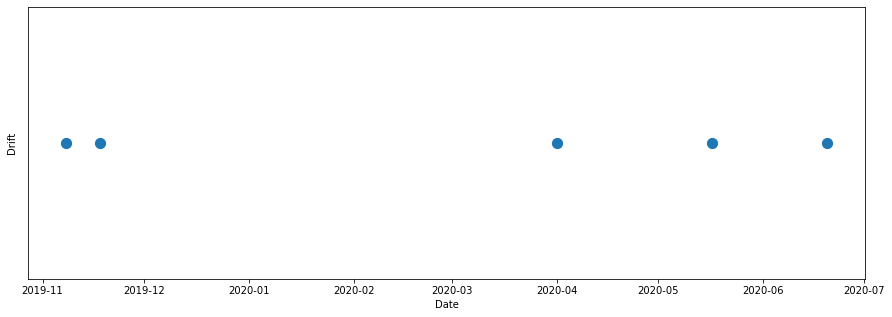

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))

scat = sns.scatterplot(data=voteDF, x="Date", y="Drift",
                                palette='deep', s=150, legend=False)

scat.set_yticklabels([])
scat.tick_params(left=False)

[Text(0, 0, 'DDM'),
 Text(0, 0, 'EDDM'),
 Text(0, 0, 'HDDM_A'),
 Text(0, 0, 'ADWIN'),
 Text(0, 0, 'Page Hinkley')]

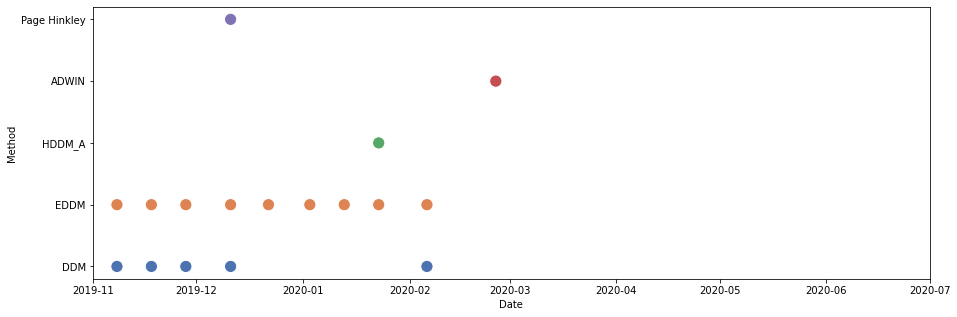

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))

fig.add_subplot(sns.scatterplot(data=plotDF, x="Date", y="Method", hue="Method",
                                palette='deep', s=150, legend=False))
ax.set_yticks(np.arange(1,6))
ax.set_xlim([date(2019,11,1), date(2020,7,1)])
ax.set_yticklabels(['DDM', 'EDDM', 'HDDM_A', 'ADWIN', 'Page Hinkley'])

# EWMA Implementation

In [ ]:
class EWMA():
    """The Exponentially Weighted Moving Average (EWMA) drift detection method class."""
    
    def __init__(self, min_instance=30, lambda_=0.2, c=1, w=0.5):
        '''
        The Exponentially Weighted Moving Average (EWMA) drift detection method class.
        :param: min_instance: quantity of instance to start detect a concept drift
        '''

        self.MINIMUM_NUM_INSTANCES = min_instance

        self.t = 1.0
        self.sum = 0.0
        self.sigma_xt = 0.0
        self.sigma_zt = 0.0
        self.z_t = 0.0
        self.lambda_ = lambda_
        self.L_t = c
        self.w = w
        
    def fit(self, classifier, vectorizer, W):
        '''
        method to fit to the current concept 
        '''
        
        for obs in W:
            x, y = vectorizer.transform(obs[:-1]).toarray(), obs[-1]
            
            try:
                yi = classifier.predict(x)
            except:
                yi = classifier.predict([x])
            
            pred = True
            if(yi != y):
                pred = False
                
            self.run(pred)
    
    def run(self, prediction):
      '''
      method to update the parameters of ewma
      :param: prediction: true if the prediction is correct, otherwise no
      '''
      prediction = 1 if prediction is False else 0

      warning_status = False
      drift_status = False

      # 1. UPDATING STATS
      self.sum += prediction
      self.sigma_xt = self.sum / self.t
      self.sigma_zt = math.sqrt(self.sigma_xt * (1.0 - self.sigma_xt) * self.lambda_ * (1.0 - math.pow(1.0 - self.lambda_, 2.0 * self.t)) / (2.0 - self.lambda_))
      self.t += 1

      self.z_t += self.lambda_ * (prediction - self.z_t)
      #L_t = 3.97 - 6.56 * self.sigma_xt + 48.73 * math.pow(self.sigma_xt, 3) - 330.13 * math.pow(self.sigma_xt, 5) + 848.18 * math.pow(self.sigma_xt, 7)

      # 2. UPDATING WARNING AND DRIFT STATUSES
      if self.t < self.MINIMUM_NUM_INSTANCES:
        return False, False

      if self.z_t > self.sigma_xt + self.L_t * self.sigma_zt:
        drift_status = True
      elif self.z_t > self.sigma_xt + self.w * self.L_t * self.sigma_zt:
        warning_status = True

      return warning_status, drift_status


    def detect(self, y_true, y_pred):
        '''
        method to monitor the index
        '''
        
        # checkint out the prediction of classifier
        pred = True
        if(y_true != y_pred):
            pred = False
        
        warning_level, change_level = self.run(pred)
        
        return warning_level, change_level

    def reset(self):
        '''
        method to reset the detector
        '''
        
        self.t = 1
        self.sum = 0
        self.sigma_xt = 0
        self.sigma_zt = 0
        self.z_t = 0

Fit Detector on Batch of current concept in training data, then run on test data

In [ ]:
train_concept = timeSampledDF[train_batch][-1000:][['Text', 'Abgelehnt']].to_numpy()
stream = datastream.copy().to_numpy()

In [ ]:
ema = EWMA(min_instance=500)
ema.fit(automl_timed_3m, vectorizer, train_concept)


In [ ]:
drift = []
i = 0

for instance in stream:
  x, y = vectorizer.transform([instance[0]]).toarray(), instance[1]

  yi = automl_timed_3m.predict(x)
  error = bool(abs(y - yi))
  warning_level, change_level = ema.run(error)

  if(change_level == True):
  # storing the time when warning was triggered
    print('Drift detected')
    drift.append(instance[2])
    ema.reset()

Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected
Drift detected


In [ ]:
ewmaDF = pd.DataFrame({'Date':drift,'Method':6})

plot2DF = pd.concat([ddmDrift, eddmDrift, hddmDrift, adwinDrift, phDrift, ewmaDF]).sort_values(by='Method')

[Text(0, 0, 'DDM'),
 Text(0, 0, 'EDDM'),
 Text(0, 0, 'HDDM_A'),
 Text(0, 0, 'ADWIN'),
 Text(0, 0, 'Page Hinkley'),
 Text(0, 0, 'EWMA')]

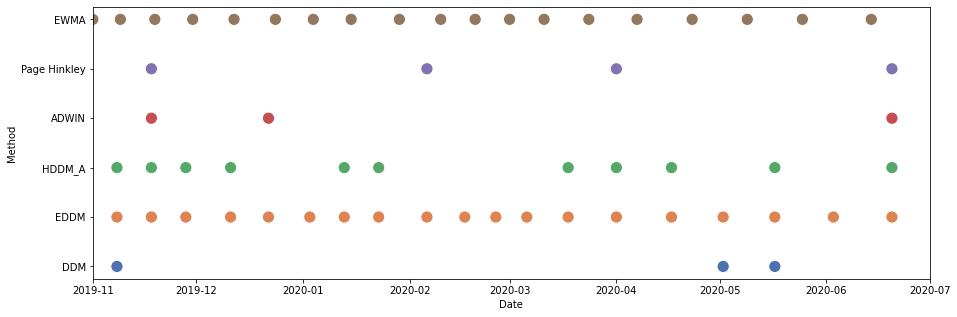

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))

fig.add_subplot(sns.scatterplot(data=plot2DF, x="Date", y="Method", hue="Method",
                                palette='deep', s=150, legend=False))
ax.set_yticks(np.arange(1,7))
ax.set_xlim([date(2019,11,1), date(2020,7,1)])
ax.set_yticklabels(['DDM', 'EDDM', 'HDDM_A', 'ADWIN', 'Page Hinkley','EWMA'])

# Linear Four Rates Model

taken from: https://github.com/thuijskens/hlfr

In [ ]:
def _compute_tpr(confusion_matrix):
    return confusion_matrix.tp / (confusion_matrix.tp + confusion_matrix.fn)


def _compute_tnr(confusion_matrix):
    return confusion_matrix.tn / (confusion_matrix.tn + confusion_matrix.fp)


def _compute_ppv(confusion_matrix):
    return confusion_matrix.tp / (confusion_matrix.tp + confusion_matrix.fp)


def _compute_npv(confusion_matrix):
    return confusion_matrix.tn / (confusion_matrix.tn + confusion_matrix.fn)


METRICS_FUNCTION_MAPPING = {
    'tpr': _compute_tpr,
    'tnr': _compute_tnr,
    'ppv': _compute_ppv,
    'npv': _compute_npv
}


class StreamingConfusionMatrix(object):
    def __init__(self):
        self.confusion_matrix = np.ones((2, 2))
        self.tp = 1
        self.fp = 1
        self.tn = 1
        self.fn = 1

    def update_confusion_matrix(self, y_true, y_pred):
        self.confusion_matrix[y_pred, y_true] += 1
        self._update_statistics()
        return self.confusion_matrix

    def reset_internals(self):
        self.confusion_matrix = np.ones((2, 2))
        self.tp = 1
        self.fp = 1
        self.tn = 1
        self.fn = 1

    def _update_statistics(self):
        self.tp = self.confusion_matrix[1, 1]
        self.fp = self.confusion_matrix[1, 0]
        self.tn = self.confusion_matrix[0, 0]
        self.fn = self.confusion_matrix[0, 1]


class PerformanceMetric(object):
    def __init__(self, metric_name, decay):
        """
        decay is a function
        :param metric_name: 
        :param decay: 
        """
        if metric_name not in ['tpr', 'tnr', 'ppv', 'npv']:
            raise ValueError('metric_name must be one of tpr, tnr, ppv, or npv, got %s' % metric_name)

        self.metric_name = metric_name
        self.decay = decay
        self.metric_value = [0.5]

        self._R = [0.5]
        self._P = [0.5]

    def reset_internals(self):
        self._R[-1] = 0.5
        self._P[-1] = 0.5

    def update_metric(self, confusion_matrix, y_true, y_pred):

        self.metric_value.append(METRICS_FUNCTION_MAPPING[self.metric_name](confusion_matrix))

        r_hat = self.update_decay(y_true, y_pred)
        n, p_hat = self.update_stats(confusion_matrix.confusion_matrix)

        return n, p_hat, r_hat

    def metric_changed(self):
        return abs(self.metric_value[-1] - self.metric_value[-2]) > 0

    def update_decay(self, y_true, y_pred):
        if self.metric_changed():
            self._R.append(self.decay * self._R[-1] + (1 - self.decay) * int(y_true == y_pred))
        else:
            self._R.append(self._R[-1])

        return self._R[-1]

    def update_stats(self, confusion_matrix):
        if self.metric_name in ['tpr', 'tnr']:
            tpr_indicator = int(self.metric_name == 'tpr')
            n = int(confusion_matrix[:, tpr_indicator].sum())

            self._P.append(confusion_matrix[tpr_indicator, tpr_indicator] / n)
        else:
            ppv_indicator = int(self.metric_name == 'ppv')
            n = int(confusion_matrix[ppv_indicator, :].sum())

            self._P.append(confusion_matrix[ppv_indicator, ppv_indicator] / n)

        return n, self._P[-1]

In [ ]:
"""
Hierarchical Linear Four Rates 
HLFR is a concept drift detection algorithm that consists of two layers:
    1. Layer-1 hypothesis test that detects a potential drift point T.
    2. Layer-2 hypothesis test that confirms the potentiality of drift point T.
    
If a drift point T is confirmed, the underlying model can be reconfigurated and the procedure restarts.
"""
import numpy as np
import itertools
import math

from scipy.stats import bernoulli


def compute_bounds(p_hat, decay, n, alpha, n_sim=1000):
    bernoulli_samples = bernoulli.rvs(p_hat, size=n * n_sim).reshape(n_sim, n)
    # TODO: Check if shapes match

    #empirical_bounds = (1 - decay) * (bernoulli_samples * (n - np.arange(1, n + 1))).sum(axis=1)
    empirical_bounds = (1 - decay) * np.matmul(bernoulli_samples, decay ** (n - np.arange(1, n + 1)).reshape(n, 1)).sum(axis=1)
    lb, ub = np.percentile(empirical_bounds, q=[alpha * 100, (1 - alpha) * 100])

    return lb, ub


def find_nearest(array, value):
    idx = np.searchsorted(array, value, side='left')
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]


class BoundsTable(object):
    def __init__(self, decay, alpha_range, p_hat_range, n_range, n_sim=1000):
        self.decay = decay
        self.alpha_range = alpha_range
        self.p_hat_range = p_hat_range
        self.n_range = n_range
        self.n_sim = n_sim

        self.bounds_table = {}

    def compute_bounds_table(self, rng_seed=123321):
        np.random.seed(rng_seed)
        grid = itertools.product(self.p_hat_range, self.n_range, self.alpha_range)
        # TODO: Is it safe to store dictionary keys as floating point values?
        self.bounds_table = {(p, n, alpha): compute_bounds(p_hat=p, alpha=alpha, decay=self.decay, n=n, n_sim=self.n_sim)
                             for (p, n, alpha) in grid}

        return self

    def lookup_bounds(self, p, n, alpha):
        # We assume here that n and alpha can be exactly matched
        p_nearest = find_nearest(self.p_hat_range, p)
        return self.bounds_table[(p_nearest, n, alpha)]


class LinearFourRates(object):
    """
    The way we code LFR will be that it takes the whole data set, and detects all potential drift points in the time
    series.
    """
    def __init__(self, decay, warn_level, detect_level, bounds_table=None):
        self.decay = decay
        self.warn_level = warn_level
        self.detect_level = detect_level
        self.bounds_table = bounds_table

        self.metrics = {metric_name: PerformanceMetric(metric_name, decay)
                        for metric_name in ['tpr', 'tnr', 'ppv', 'npv']}
        self.warn_time = 0
        self.confusion_matrix = StreamingConfusionMatrix()
        self.concept_shift_times = []

    def _compute_bounds_table(self, n_samples, rng_seed=4711):
        alpha_range = np.array([self.warn_level, self.detect_level])
        p_hat_range = np.arange(1, 100) / 100.0
        n_range = np.arange(2, n_samples + 1)

        self.bounds_table = BoundsTable(self.decay, alpha_range, p_hat_range, n_range, n_sim=1000)
        self.bounds_table.compute_bounds_table(rng_seed=rng_seed)

        return self.bounds_table

    def detect_drift_points(self, y_obs, y_pred):
        """
        Data API. This takes the model and the data, and computes the performance metrics and confusion matrix
        before passing these on to _detect_drift_point
        """
        n_samples = y_obs.shape[0]

        if self.bounds_table is None:
            self._compute_bounds_table(n_samples)

        for t, (y, y_hat) in enumerate(zip(y_obs, y_pred)):
            self.confusion_matrix.update_confusion_matrix(y, y_hat)

            warnings = []
            detections = []

            for metric in self.metrics.values():
                n, p_hat, r_hat = metric.update_metric(self.confusion_matrix, y, y_hat)

                lb_warn, ub_warn = self.bounds_table.lookup_bounds(p=p_hat, n=n, alpha=self.warn_level)
                lb_detect, ub_detect = self.bounds_table.lookup_bounds(p=p_hat, n=n, alpha=self.detect_level)

                warn_shift = (r_hat <= lb_warn) or (r_hat >= ub_warn)
                detect_shift = (r_hat <= lb_detect) or (r_hat >= ub_detect)

                # NOTE: lb = ub = 0.0. So r_hat >= ub_warn is satisfied... bounds table computation is wrong
                print("Sample %i: metric %s, R: %.3f, Warn LB: %.3f Warn UB: %.f, Detect LB: %.3f, Detect UB: %.3f, warn: %s detect: %s"
                      % (t, metric.metric_name, r_hat, lb_warn, ub_warn, lb_detect, ub_detect, warn_shift, detect_shift))

                warnings.append(warn_shift)
                detections.append(detect_shift)

            if any(warnings) and self.warn_time is None:
                self.warn_time = t
            elif all([not warning for warning in warnings]) and self.warn_time is not None:
                self.warn_time = None

            if any(detections):
                self.concept_shift_times.append(t)

                # Reset all metrics and confusion matrix
                self.confusion_matrix.reset_internals()
                self.warn_time = 0
                for metric in self.metrics.values():
                    metric.reset_internals()

            if t % 100 == 0:
                print("Sample %i" % t)

        return self

In [ ]:
lfr = LinearFourRates(warn_level=0.01, detect_level=1 / 100, decay=0.9)

y_pred = automl_timed.predict(vectorizer.transform(datastream.x).toarray()).astype('int32')
y_true = datastream.y.astype('int32')


In [ ]:
lfr_results = lfr.detect_drift_points(y_true, y_pred)

In [ ]:
lfr_load = open ("lfr_results.pk", "rb")
test = pickle.load(lfr_load)